In [3]:
import torch
import gpytorch
from data import PVWeatherLoader

In [4]:
# data parameters
DAY_INIT = 40
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 10
MINUTE_INTERVAL = 60
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 10
# create a tuple of 4 coordinates that form a polygon in the uk
# and a circle with a radius of r
CIRCLE_COORDS = (55, -1.5)
RADIUS = 0.3
POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [5]:
loader = PVWeatherLoader(
    # number of days to get data for
    n_days=N_DAYS,
    # initial day of the data for that season
    # look at the data frame to see which day it is
    day_init=DAY_INIT,
    # number of systems to extract
    n_systems=N_SYSTEMS,
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    # the minute interval our data is sampled at 
    # (e.g. 60 for hourly, 30 for half hourly, 15 for 15 minutes, etc.)
    minute_interval=MINUTE_INTERVAL,
    # the minimum and maximum hour of the day to use
    # (e.g. 8 and 15 for 8am to 3pm)
    day_min=DAY_MIN,
    day_max=DAY_MAX,
    folder_name='pv_data',
    file_name='pv_and_weather.csv',
    distance_method='circle',
    # optionally use a season
    season='winter',
    # optionally drop series with nan values
    drop_nan=False
)

==> Loading data
==> Loaded data in: 0 m : 0 sec



/Users/eirikbaekkelund/Desktop/UCL/Code/Dissertation/data/utils.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('season', axis=1, inplace=True)


In [6]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=train_y.size(-1), rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)


In [15]:
from data.utils import train_test_split
# input for hadamard model
dict_input = {'x_train' : [], 
              'y_train' : [], 
              'x_test' : [], 
              'y_test' : [],
              'task_indices_train' : [],
              'task_indices_test' : []}


# containts the data for each task at same time intervals
for i, (X, y) in enumerate(loader):
    x_train, y_train, x_test, y_test = train_test_split(X, y, hour=12, minute_interval=60, day_min=DAY_MIN, day_max=DAY_MAX, n_hours=12)
    n_tr, d = x_train.shape
    n_te = x_test.shape[0]
    task_index_train = torch.ones(n_tr, d, dtype=torch.long) * i
    task_index_test = torch.ones(n_te, d, dtype=torch.long) * i
    dict_input['x_train'].append(x_train)
    dict_input['y_train'].append(y_train)
    dict_input['x_test'].append(x_test)
    dict_input['y_test'].append(y_test)
    dict_input['task_indices_train'].append(task_index_train)
    dict_input['task_indices_test'].append(task_index_test)

task_indices_train = torch.cat(dict_input['task_indices_train'])
task_indices_test = torch.cat(dict_input['task_indices_test'])
x_train = torch.cat(dict_input['x_train'])
y_train = torch.cat(dict_input['y_train'])
x_test = torch.cat(dict_input['x_test'])
y_test = torch.cat(dict_input['y_test'])
_y_tr = torch.stack(dict_input['y_train'], dim=-1)
_y_te = torch.stack(dict_input['y_test'], dim=-1)

In [16]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([520, 5]),
 torch.Size([520]),
 torch.Size([96, 5]),
 torch.Size([96]))

In [17]:
from kernels import get_mean_covar
mean, covar = get_mean_covar()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MultitaskGPModel((x_train, task_indices_train), y_train, likelihood)


In [21]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(250):
    optimizer.zero_grad()
    output = model(x_train, task_indices_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    if (i+ 1) % 20 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, 200, loss.item()))

Iter 20/200 - Loss: -0.797
Iter 40/200 - Loss: -0.805
Iter 60/200 - Loss: -0.812
Iter 80/200 - Loss: -0.805
Iter 100/200 - Loss: -0.810
Iter 120/200 - Loss: -0.818
Iter 140/200 - Loss: -0.798
Iter 160/200 - Loss: -0.809
Iter 180/200 - Loss: -0.815
Iter 200/200 - Loss: -0.819
Iter 220/200 - Loss: -0.805
Iter 240/200 - Loss: -0.814


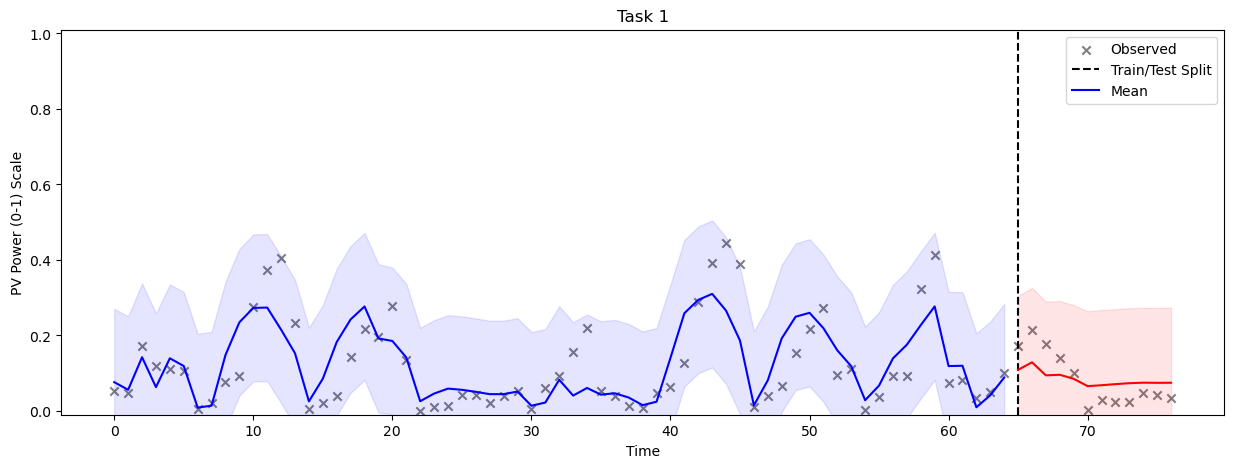

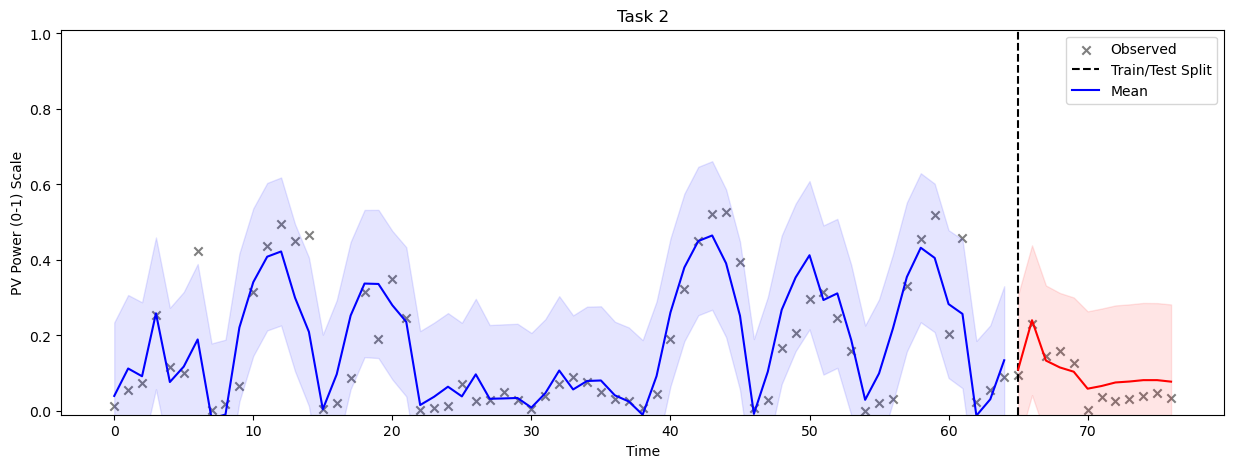

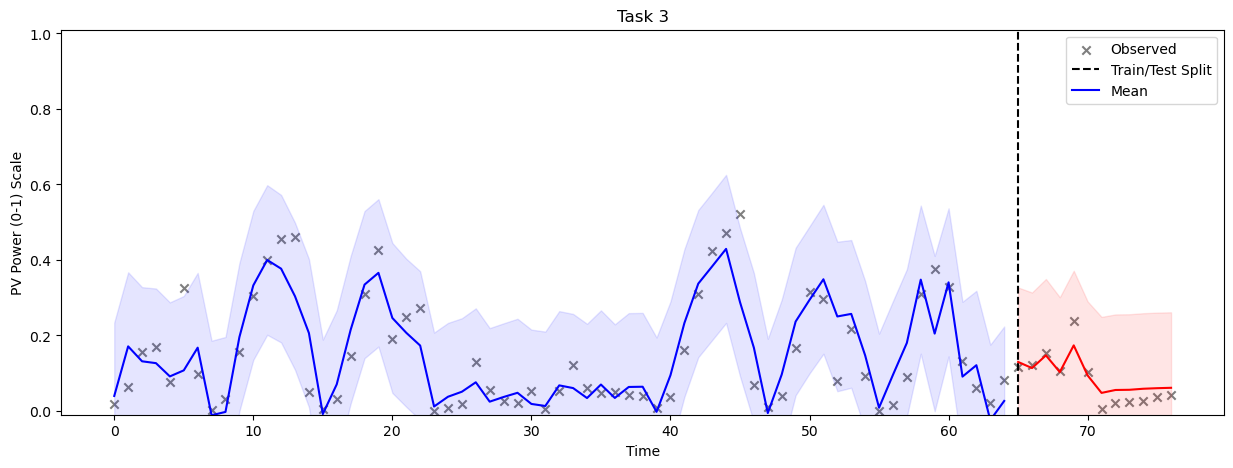

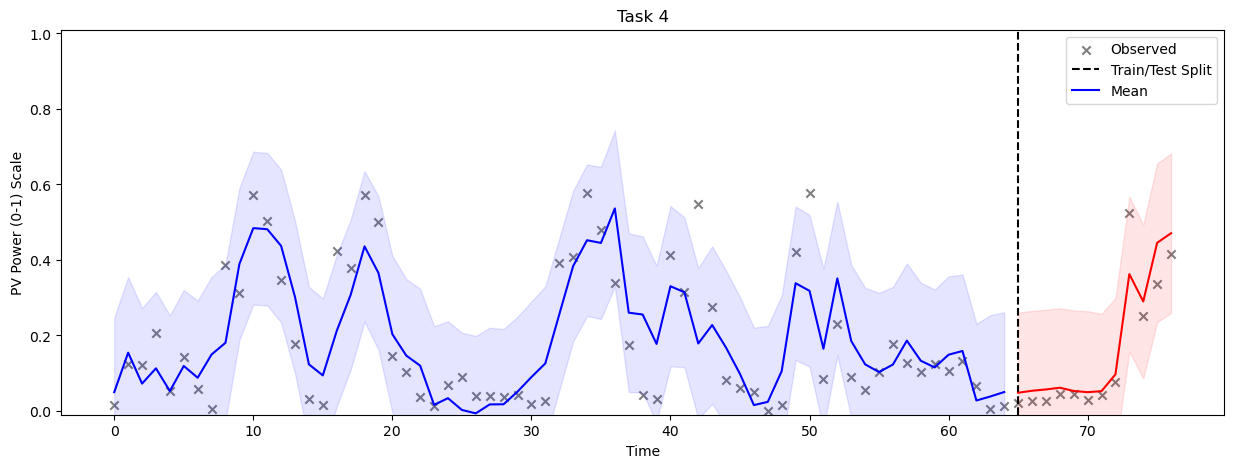

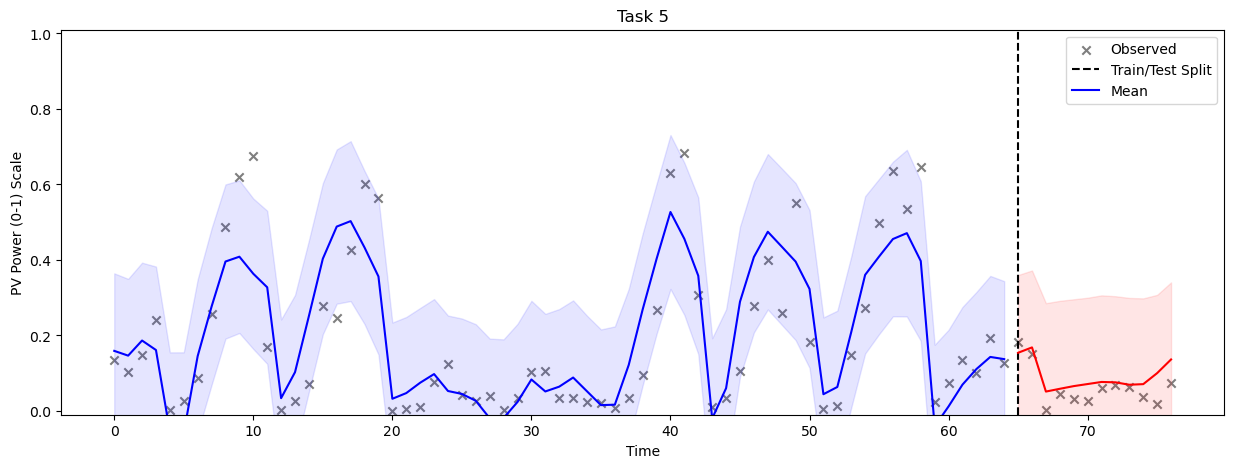

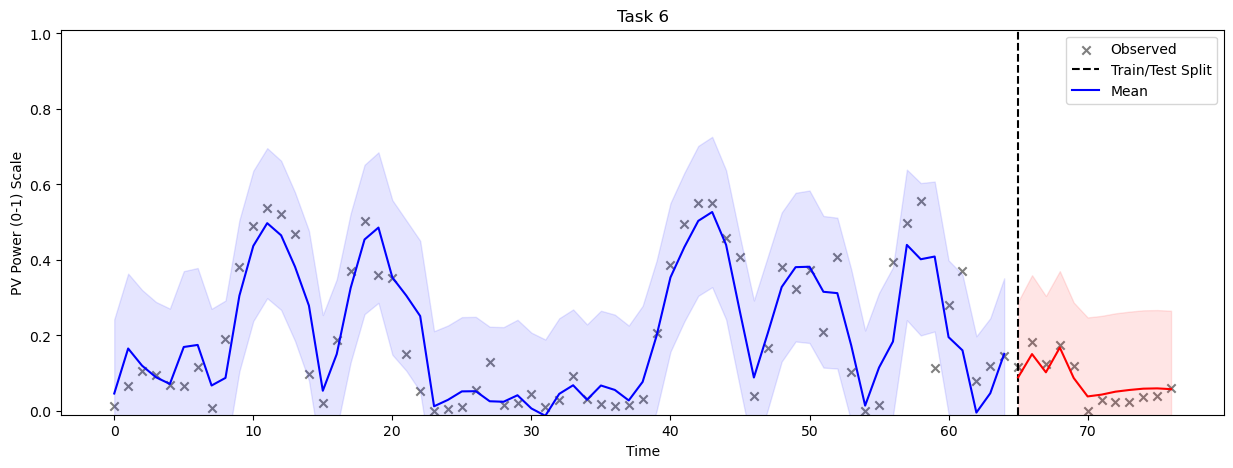

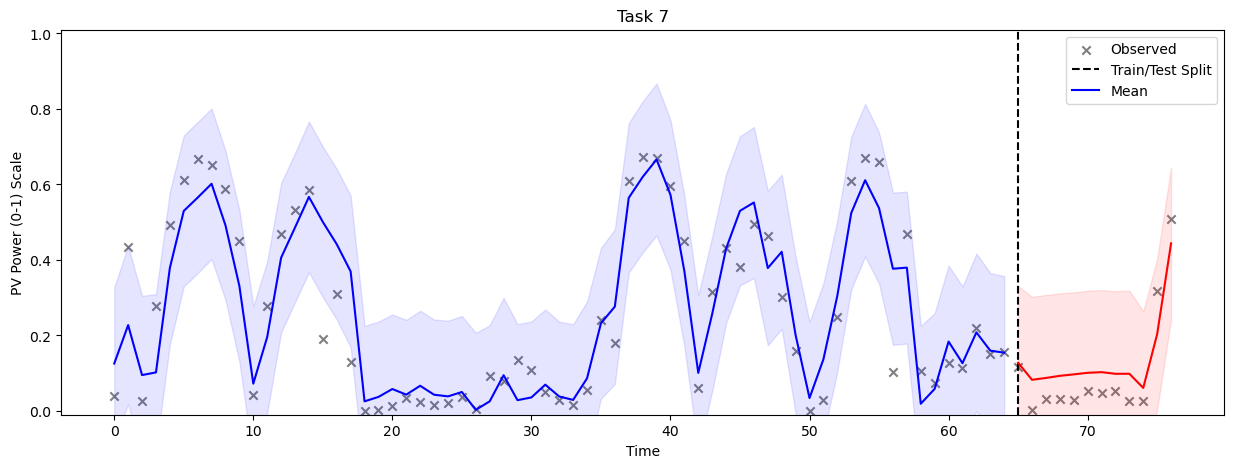

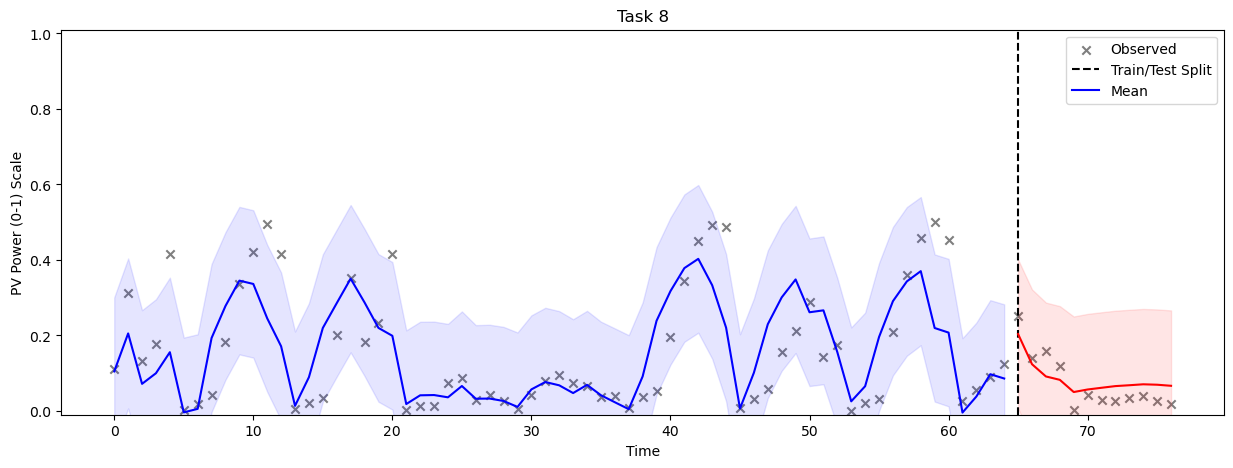

In [22]:
# make predictions for each task and plot the results on training and test data
from matplotlib import pyplot as plt
import numpy as np
model.eval()
likelihood.eval()

for i in range(_y_tr.size(-1)):
    y_tr, y_te = _y_tr[:, i], _y_te[:, i]
    t = np.arange(0, len(y_tr) + len(y_te))
    t_tr, t_te = t[:len(y_tr)], t[len(y_tr):]

    plt.figure(figsize=(15,5))
    plt.scatter(t_tr, y_tr, label='Observed', color='black', marker='x', alpha=0.5)
    plt.scatter(t_te, y_te,  color='k', marker='x', alpha=0.5)
    plt.axvline(x=len(y_tr), color='k', linestyle='--', label='Train/Test Split')

    with torch.no_grad():
        pred_dist_tr = likelihood(model(dict_input['x_train'][i], dict_input['task_indices_train'][i]))
        pred_dist_te = likelihood(model(dict_input['x_test'][i], dict_input['task_indices_test'][i]))
    
    mean = pred_dist_tr.mean.detach().numpy()
    lower, upper = pred_dist_tr.confidence_region()
    plt.plot(t_tr, mean, color='b', label='Mean')
    plt.fill_between(t_tr, lower.detach().numpy(), upper.detach().numpy(), color='b', alpha=0.1)

    mean = pred_dist_te.mean.detach().numpy()
    lower, upper = pred_dist_te.confidence_region()
    plt.plot(t_te, mean, color='r')
    plt.fill_between(t_te, lower.detach().numpy(), upper.detach().numpy(), color='r', alpha=0.1)

    plt.ylim(-0.01, 1.01)
    plt.title(f'Task {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('PV Power (0-1) Scale')
    plt.legend()
    plt.show(); 